In [1]:
import pandas as pd
import glob 
import numpy as np

In [2]:
recall_glob = glob.glob('results/recall' + '*.csv')
beh_glob = glob.glob('results/beh' + '*.csv')

In [3]:
recall, beh = [], []

for file in recall_glob:
    df = pd.read_csv(file, encoding = 'cp1250')
    recall.append(df)

for file in beh_glob:
    df = pd.read_csv(file, encoding = 'cp1250')
    beh.append(df)

In [4]:
beh = [df[~df['trial_type'].str.endswith('_training')] for df in beh]

In [5]:
semantic = [df[df['trial_type'].str.startswith('semantic_')] for df in beh]
perceptual = [df[df['trial_type'].str.startswith('perceptual_')] for df in beh]

In [6]:
semantic[0]

,trial_type,trial_number,sentence,correct_answer,acc,answer_rt
78,semantic_experiment0,0,Ananas to warzywo,False,0,2.083497
79,semantic_experiment0,1,Brzuch jest częścią ciała.,True,1,1.000161
80,semantic_experiment0,2,Wilk poluje w grupach,True,1,1.766882
81,semantic_experiment0,3,Kangur potrafi skakać,True,1,1.316812
82,semantic_experiment0,4,Woda jest niezbędna do życia,True,1,1.033460
...,...,...,...,...,...,...
205,semantic_experiment2,39,Koń to zwierzę kopytne,True,1,1.066822
206,semantic_experiment2,40,Czarna wdowa jest różowa,False,1,1.200265
207,semantic_experiment2,41,Kozaki to rodzaj obuwia,True,1,1.416844
208,semantic_experiment2,42,Bocian przynosi dzieci,False,0,0.783529


In [7]:
first_sem = [df[:int(len(df)/2)] for df in semantic]
second_sem = [df[int(len(df)/2):] for df in semantic]

first_perc = [df[:int(len(df)/2)] for df in perceptual]
second_perc = [df[int(len(df)/2):] for df in perceptual]

In [8]:
for df in first_sem:
    df.loc[df["answer_rt"] == -1, 'answer_rt'] = np.nan
for df in second_sem:
    df.loc[df["answer_rt"] == -1, 'answer_rt'] = np.nan
for df in first_perc:
    df.loc[df["answer_rt"] == -1, 'answer_rt'] = np.nan
for df in second_perc:
    df.loc[df["answer_rt"] == -1, 'answer_rt'] = np.nan

In [9]:
mean_fs = [df["answer_rt"].mean() for df in first_sem]
mean_ss = [df["answer_rt"].mean() for df in second_sem]

mean_fp = [df["answer_rt"].mean() for df in first_perc]
mean_sp = [df["answer_rt"].mean() for df in second_perc]

In [10]:
sd_fs = [df["answer_rt"].std() for df in first_sem]
sd_ss = [df["answer_rt"].std() for df in second_sem]

sd_fp = [df["answer_rt"].std() for df in first_perc]
sd_sp = [df["answer_rt"].std() for df in second_perc]

In [11]:
# 0 - offline, 1 - online

for df, mean, std in zip(first_sem, mean_fs, sd_fs):
    df['RTV'] = [abs((mean - rt)/std) for rt in df['answer_rt']]
for df, mean, std in zip(second_sem, mean_ss, sd_ss):
    df['RTV'] = [abs((mean - rt)/std) for rt in df['answer_rt']]
for df, mean, std in zip(first_perc, mean_fp, sd_fp):
    df['RTV'] = [abs((mean - rt)/std) for rt in df['answer_rt']]
for df, mean, std in zip(second_perc, mean_sp, sd_sp):
    df['RTV'] = [abs((mean - rt)/std) for rt in df['answer_rt']]

/var/folders/d5/1jwv81jn6yg7294shcdcf4m40000gn/T/ipykernel_96359/663596272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RTV'] = [abs((mean - rt)/std) for rt in df['answer_rt']]
/var/folders/d5/1jwv81jn6yg7294shcdcf4m40000gn/T/ipykernel_96359/663596272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RTV'] = [abs((mean - rt)/std) for rt in df['answer_rt']]
/var/folders/d5/1jwv81jn6yg7294shcdcf4m40000gn/T/ipykernel_96359/663596272.py:4: SettingWithCopyWarning: 
A value is trying to be set on

In [12]:
median_fs = [df["RTV"].median() for df in first_sem]
median_ss = [df["RTV"].median() for df in second_sem]

median_fp = [df["RTV"].median() for df in first_perc]
median_sp = [df["RTV"].median() for df in second_perc]

In [13]:
# 0 - offline, 1 - online

for df, median in zip(first_sem, median_fs):
    df['STATE'] = [0 if rtv > median else 1 for rtv in df['RTV']]
for df, mean, std in zip(second_sem, mean_ss, sd_ss):
    df['STATE'] = [0 if rtv > median else 1 for rtv in df['RTV']]
for df, mean, std in zip(first_perc, mean_fp, sd_fp):
    df['STATE'] = [0 if rtv > median else 1 for rtv in df['RTV']]
for df, mean, std in zip(second_perc, mean_sp, sd_sp):
    df['STATE'] = [0 if rtv > median else 1 for rtv in df['RTV']]

/var/folders/d5/1jwv81jn6yg7294shcdcf4m40000gn/T/ipykernel_96359/611900336.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['STATE'] = [0 if rtv > median else 1 for rtv in df['RTV']]
/var/folders/d5/1jwv81jn6yg7294shcdcf4m40000gn/T/ipykernel_96359/611900336.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['STATE'] = [0 if rtv > median else 1 for rtv in df['RTV']]
/var/folders/d5/1jwv81jn6yg7294shcdcf4m40000gn/T/ipykernel_96359/611900336.py:4: SettingWithCopyWarning: 
A value is trying to be set 

In [14]:
second_sem[0]['STATE'].value_counts()

STATE
1    30
0    14
Name: count, dtype: int64

In [15]:
for i,x in enumerate(first_perc):
    print(f"first: {first_perc[i]['STATE'].value_counts()}")
    print(f"sec: {second_perc[i]['STATE'].value_counts()}")
    print()

first: STATE
1    25
0    19
Name: count, dtype: int64
sec: STATE
1    28
0    16
Name: count, dtype: int64

first: STATE
1    22
0    22
Name: count, dtype: int64
sec: STATE
0    26
1    18
Name: count, dtype: int64

first: STATE
0    24
1    20
Name: count, dtype: int64
sec: STATE
1    25
0    19
Name: count, dtype: int64

first: STATE
1    30
0    14
Name: count, dtype: int64
sec: STATE
1    24
0    20
Name: count, dtype: int64

first: STATE
1    25
0    19
Name: count, dtype: int64
sec: STATE
1    23
0    21
Name: count, dtype: int64

first: STATE
0    27
1    17
Name: count, dtype: int64
sec: STATE
0    24
1    20
Name: count, dtype: int64



In [16]:
merged_perc = []
for first, second in zip(first_perc, second_perc):
    df_merg = pd.concat([first, second])
    merged_perc.append(df_merg)

merged_sem = []
for first, second in zip(first_sem, second_sem):
    df_merg = pd.concat([first, second])
    merged_sem.append(df_merg)


In [17]:
merged_sem[0]

,trial_type,trial_number,sentence,correct_answer,acc,answer_rt,RTV,STATE
78,semantic_experiment0,0,Ananas to warzywo,False,0,2.083497,0.706119,1
79,semantic_experiment0,1,Brzuch jest częścią ciała.,True,1,1.000161,0.896724,0
80,semantic_experiment0,2,Wilk poluje w grupach,True,1,1.766882,0.237672,1
81,semantic_experiment0,3,Kangur potrafi skakać,True,1,1.316812,0.428226,1
82,semantic_experiment0,4,Woda jest niezbędna do życia,True,1,1.033460,0.847457,0
...,...,...,...,...,...,...,...,...
205,semantic_experiment2,39,Koń to zwierzę kopytne,True,1,1.066822,0.543329,1
206,semantic_experiment2,40,Czarna wdowa jest różowa,False,1,1.200265,0.288823,1
207,semantic_experiment2,41,Kozaki to rodzaj obuwia,True,1,1.416844,0.124243,1
208,semantic_experiment2,42,Bocian przynosi dzieci,False,0,0.783529,1.083636,0


In [18]:
rec_in_task = []

for df in recall:
    new = df.loc[df['in_task'] == True]
    new.rename(columns = {'acc': 'recall_acc'}, inplace= True)
    rec_in_task.append(new)

/var/folders/d5/1jwv81jn6yg7294shcdcf4m40000gn/T/ipykernel_96359/3378798381.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new.rename(columns = {'acc': 'recall_acc'}, inplace= True)


In [19]:
m_sem_rec, m_perc_rec = [], []

for task, recall in zip(merged_sem,rec_in_task):
    result = pd.merge(task, recall, on='sentence')
    m_sem_rec.append(result)

for task, recall in zip(merged_perc,rec_in_task):
    result = pd.merge(task, recall, on='sentence')
    m_perc_rec.append(result)

In [20]:
m_sem_rec[0]

,trial_type,trial_number,sentence,correct_answer,acc,answer_rt,RTV,STATE,in_task,recall_acc
0,semantic_experiment0,2,Wilk poluje w grupach,True,1,1.766882,0.237672,1,True,1
1,semantic_experiment0,3,Kangur potrafi skakać,True,1,1.316812,0.428226,1,True,1
2,semantic_experiment0,5,Jemioła to zwierzę,False,1,1.433330,0.255832,1,True,1
3,semantic_experiment0,7,Orka to ssak wodny,True,1,2.150216,0.804832,0,True,0
4,semantic_experiment0,9,Elektryk naprawia urządzenia,True,1,1.616888,0.015751,1,True,0
5,semantic_experiment0,13,Żołądek trawi pokarm.,True,1,1.150172,0.674777,1,True,1
6,semantic_experiment0,14,Jagnięcina to mięso z kury,False,1,1.250145,0.526863,1,True,1
7,semantic_experiment0,15,Paznokcie chronią palce.,True,1,1.366845,0.354200,1,True,1
8,semantic_experiment0,17,Krawiec szyje ubrania,True,1,2.233372,0.927865,0,True,1
9,semantic_experiment0,18,Wściekłość to negatywna emocja,True,1,1.533539,0.107568,1,True,1


In [21]:
sem_cleared, per_cleared = [], []
for df in m_sem_rec:
    df = df.drop(columns = ['trial_number', 'in_task'])
    sem_cleared.append(df)

for df in m_perc_rec:
    df = df.drop(columns = ['trial_number', 'in_task'])
    per_cleared.append(df)

In [22]:
sem_results = []
perc_results = []

for x in sem_cleared:
    online = x.loc[x['STATE'] == 1]
    offline = x.loc[x['STATE'] == 0]
    trial_count = len(x)
    online_cor, offline_cor = online['recall_acc'].value_counts()
    print(online_cor)
    sem_results.append([online_cor/trial_count, offline_cor/trial_count])

for x in per_cleared:
    online = x.loc[x['STATE'] == 1]
    offline = x.loc[x['STATE'] == 0]
    trial_count = len(x)
    online_cor, offline_cor = online['recall_acc'].value_counts()
    print(online_cor)
    perc_results.append([online_cor/trial_count, offline_cor/trial_count])

final_results = []
for x, y in zip(sem_results, perc_results):
    listn = [x[0],x[1],y[0],y[1]]
    final_results.append(listn)

final_results_df = pd.DataFrame(final_results, columns = ['semantic_online', 'semantic_offline', 'perceptual_online', 'perceptual_offline'])

final_results_df["delta_SEM"] = final_results_df['semantic_online'] - final_results_df['semantic_offline']
final_results_df["delta_PERC"] = final_results_df['perceptual_online'] - final_results_df['perceptual_offline']
final_results_df

18
10
11
15
24
19
19
21
17
21
18
12


,semantic_online,semantic_offline,perceptual_online,perceptual_offline,delta_SEM,delta_PERC
0,0.486486,0.162162,0.475000,0.100000,0.324324,0.375000
1,0.263158,0.105263,0.403846,0.096154,0.157895,0.307692
2,0.275000,0.275000,0.377778,0.111111,0.000000,0.266667
3,0.348837,0.139535,0.446809,0.234043,0.209302,0.212766
4,0.600000,0.025000,0.418605,0.093023,0.575000,0.325581
5,0.387755,0.122449,0.333333,0.083333,0.265306,0.250000


In [23]:
final_results_df.to_csv('initial.csv')

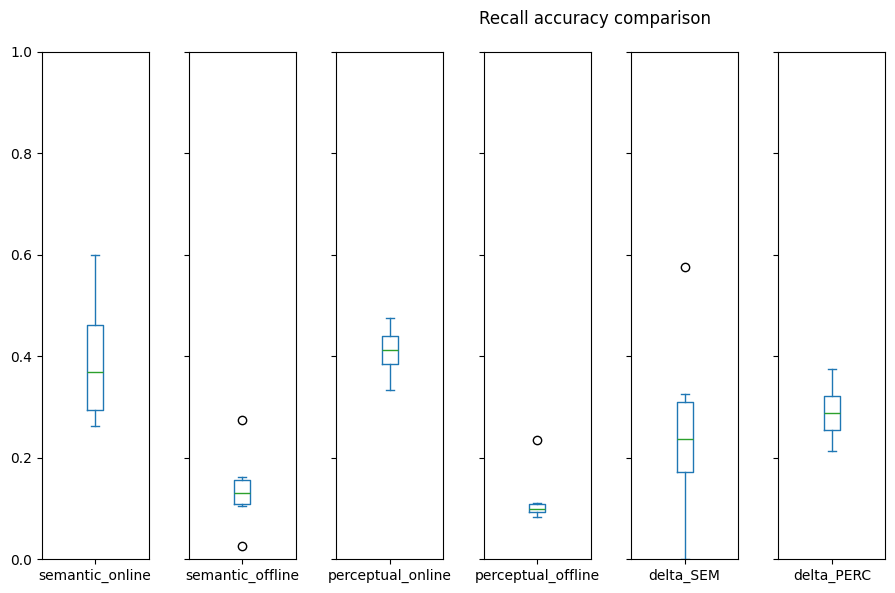

In [32]:
import matplotlib.pyplot as plt

# Sample data

# Using pandas plot method
final_results_df.plot(kind='box', subplots=True, layout=(1, len(df.columns)), figsize=(12, 6), sharey=True, title = "Recall accuracy comparison", ylim = (0,1))
plt.tight_layout()
plt.show()

In [25]:
semantic

[               trial_type  trial_number                      sentence  \
 78   semantic_experiment0             0             Ananas to warzywo   
 79   semantic_experiment0             1   Brzuch jest częścią ciała.    
 80   semantic_experiment0             2         Wilk poluje w grupach   
 81   semantic_experiment0             3         Kangur potrafi skakać   
 82   semantic_experiment0             4  Woda jest niezbędna do życia   
 ..                    ...           ...                           ...   
 205  semantic_experiment2            39        Koń to zwierzę kopytne   
 206  semantic_experiment2            40      Czarna wdowa jest różowa   
 207  semantic_experiment2            41       Kozaki to rodzaj obuwia   
 208  semantic_experiment2            42        Bocian przynosi dzieci   
 209  semantic_experiment2            43          Drzwi są na podłodze   
 
     correct_answer  acc  answer_rt  
 78           False    0   2.083497  
 79            True    1   1.00016

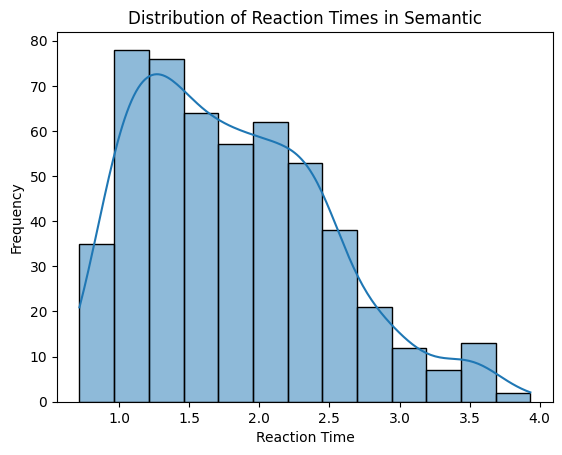

In [26]:
import seaborn as sns

reaction_times_semantic = pd.concat([df['answer_rt'] for df in semantic], ignore_index=True)

sns.histplot(reaction_times_semantic, kde=True)
plt.xlabel('Reaction Time')
plt.ylabel('Frequency')
plt.title('Distribution of Reaction Times in Semantic')
plt.show()


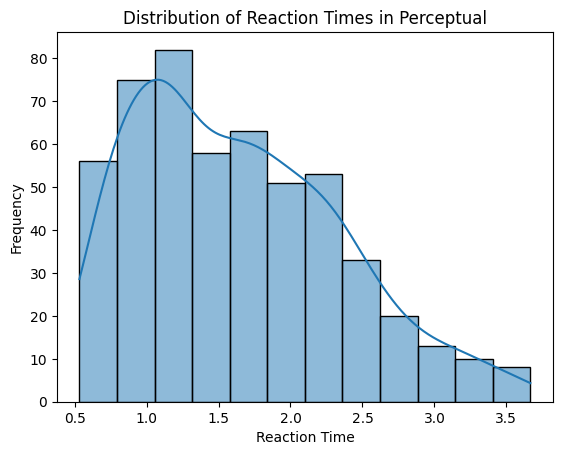

In [27]:
reaction_times_perceptual = pd.concat([df['answer_rt'] for df in perceptual], ignore_index=True)

sns.histplot(reaction_times_perceptual, kde=True)
plt.xlabel('Reaction Time')
plt.ylabel('Frequency')
plt.title('Distribution of Reaction Times in Perceptual')
plt.show()


In [28]:
semantic_mean_reaction_time = reaction_times_semantic.mean()
semantic_std_reaction_time = reaction_times_semantic.std()
semantic_min_reaction_time = reaction_times_semantic.min()
semantic_max_reaction_time = reaction_times_semantic.max()

perceptual_mean_reaction_time = reaction_times_perceptual.mean()
perceptual_std_reaction_time = reaction_times_perceptual.std()
perceptual_min_reaction_time = reaction_times_perceptual.min()
perceptual_max_reaction_time = reaction_times_perceptual.max()


In [29]:
print(f"semantic_mean_reaction_time: {semantic_mean_reaction_time}\nsemantic_std_reaction_time: {semantic_std_reaction_time}\nsemantic_min_reaction_time: {semantic_min_reaction_time}\nsemantic_max_reaction_time: {semantic_max_reaction_time}\n\nperceptual_mean_reaction_time: {perceptual_mean_reaction_time}\nperceptual_std_reaction_time: {perceptual_std_reaction_time}\nperceptual_min_reaction_time: {perceptual_min_reaction_time}\nperceptual_max_reaction_time: {3.666825}\n")

semantic_mean_reaction_time: 1.818940612934313
semantic_std_reaction_time: 0.6773430290082675
semantic_min_reaction_time: 0.7168355000030715
semantic_max_reaction_time: 3.9334037999942666

perceptual_mean_reaction_time: 1.6390274055554015
perceptual_std_reaction_time: 0.7147435525029836
perceptual_min_reaction_time: 0.5335749000005308
perceptual_max_reaction_time: 3.666825



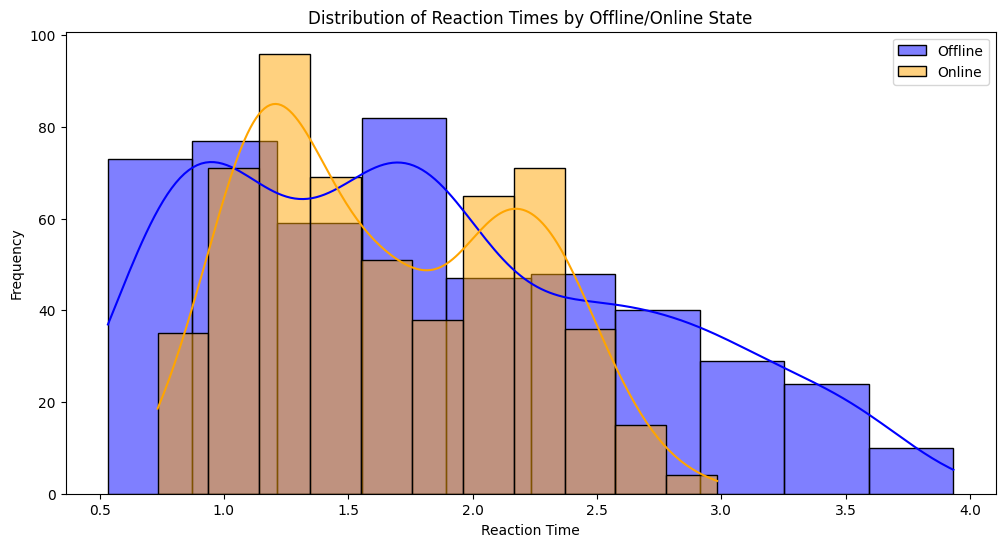

In [30]:
dfs = merged_sem + merged_perc

combined_df = pd.concat(dfs, ignore_index=True)

reaction_times_state_0 = combined_df[combined_df['STATE'] == 0]['answer_rt']
reaction_times_state_1 = combined_df[combined_df['STATE'] == 1]['answer_rt']

plt.figure(figsize=(12, 6))

sns.histplot(reaction_times_state_0, kde=True, color='blue', label='Offline')
sns.histplot(reaction_times_state_1, kde=True, color='orange', label='Online')

plt.xlabel('Reaction Time')
plt.ylabel('Frequency')
plt.title('Distribution of Reaction Times by Offline/Online State')
plt.legend()
plt.show()


In [31]:
df.max()

trial_type              perceptual_experiment2
sentence          Świerk jest drzewem iglastym
correct_answer                            True
acc                                          1
answer_rt                             3.116764
RTV                                   1.915614
STATE                                        1
recall_acc                                   1
dtype: object